# Test MLP width, height and regularisation

## Main Questions

* Is a narrow architecture smoother
* Is regularisation helping to make it smoother
* Are the different y encoding different in smoothness.

In [14]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'n_wdr'

folder = f'../../runs/{run}/train'
merged_folder = f'../../runs/{run}/merged'

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']

def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, confusion_matrix_df, synthethetic_df = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

metrics_df.columns

Index(['hidden_size', 'layers', 'lr', 'regularisation', 'y_encoding', 'name',
       'value', 'cv_split', 'epoch', 'set'],
      dtype='object')

In [4]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
labels

['y_encoding', 'lr', 'regularisation', 'layers', 'hidden_size']

In [5]:
metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

/home/local/MPIB-BERLIN/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


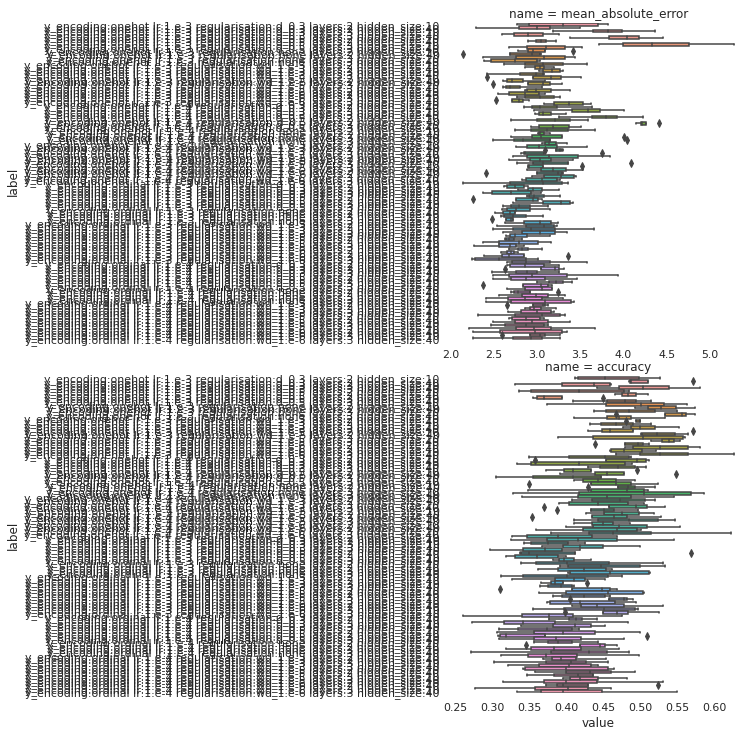

In [10]:
w = (
    (metrics_df['name'].isin(['accuracy', 'mean_absolute_error'])) &
    (metrics_df['set'] == 'test') & 
    (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]
# df['y_ordinal'] = df['y_ordinal'].astype(str)
df = df.sort_values(labels)
sns.catplot(data=df, x='value', row='name', y='label', orient='h', kind='box', sharex=False)

In [32]:
df['layers'].value_counts()

2    192
3    192
Name: layers, dtype: int64

In [33]:
to_string = ['layers', 'hidden_size']
metrics_df[to_string] = metrics_df[to_string].astype(str)

label_ref = {
    'regularisation': 'none',
    'layers': 2,
    'hidden_size': 10,
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

model_str = f"value ~ {'+'.join(label_str)}"
model_str

"value ~ y_encoding+lr+C(regularisation, Treatment(reference='none'))+C(layers, Treatment(reference='2'))+C(hidden_size, Treatment(reference='10'))"

In [38]:
# positive coef -> better

import statsmodels.formula.api as smf
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]
    # (metrics_df['lr'] == '1.e-3') & 

results = smf.glm(f"value ~ {'+'.join(label_str)}", data=df).fit()


print(results.summary().tables[1])

                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      0.4826      0.012     39.496      0.000       0.459       0.507
y_encoding[T.ordinal]                                         -0.0634      0.008     -7.779      0.000      -0.079      -0.047
lr[T.1.e-4]                                                   -0.0237      0.008     -2.906      0.004      -0.040      -0.008
C(regularisation, Treatment(reference='none'))[T.d_0.3]       -0.0207      0.014     -1.467      0.142      -0.048       0.007
C(regularisation, Treatment(reference='none'))[T.d_0.5]       -0.0401      0.014     -2.845      0.004      -0.068      -0.012
C(regularisation, Treatment(reference='none'))[T.wd_1.e-3]    -0.0208      0.014     -1.476      0.140      -0.

In [12]:
# negative coef -> better

import statsmodels.formula.api as smf
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

results = smf.glm(f"value ~ {'+'.join(labels)}", data=df).fit()
print(results.summary().tables[1])

                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.2950      0.107     30.692      0.000       3.085       3.505
y_encoding[T.ordinal]         -0.2771      0.036     -7.718      0.000      -0.347      -0.207
lr[T.1.e-4]                    0.1297      0.036      3.613      0.000       0.059       0.200
regularisation[T.d_0.5]        0.2228      0.062      3.584      0.000       0.101       0.345
regularisation[T.none]        -0.1719      0.062     -2.764      0.006      -0.294      -0.050
regularisation[T.wd_1.e-3]    -0.0431      0.062     -0.693      0.488      -0.165       0.079
regularisation[T.wd_1.e-5]    -0.1673      0.062     -2.690      0.007      -0.289      -0.045
regularisation[T.wd_1.e-6]    -0.1597      0.062     -2.569      0.010      -0.282      -0.038
layers                         0.0295      0.036  

In [9]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['layers'] == 'two_40') & 
    (metrics_df['y_encoding'] == 'ordinal')
)

df = metrics_df[w].reset_index()

sns.relplot(data=df, y='value', x='epoch', hue='lr', style='lr', row='batch_size', col='set', kind='line')


ValueError: Could not interpret value `batch_size` for parameter `row`

In [ ]:
best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    metrics_df = metrics_df.reset_index(drop=True)
    gb_col = list(set(metrics_df.columns) - set(['cv_split', 'value']))
    df_g = metrics_df.groupby(gb_col)['value'].median().reset_index()
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}
    print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')

Best performance for metric mean_absolute_error with a value of 2.557208218232044 is lr:1.e-3 batch_size:10 layers:two_40 y_encoding:onehot in epoch 710
Best performance for metric accuracy with a value of 0.5240963855421688 is lr:1.e-3 batch_size:10 layers:two_10 y_encoding:onehot in epoch 950


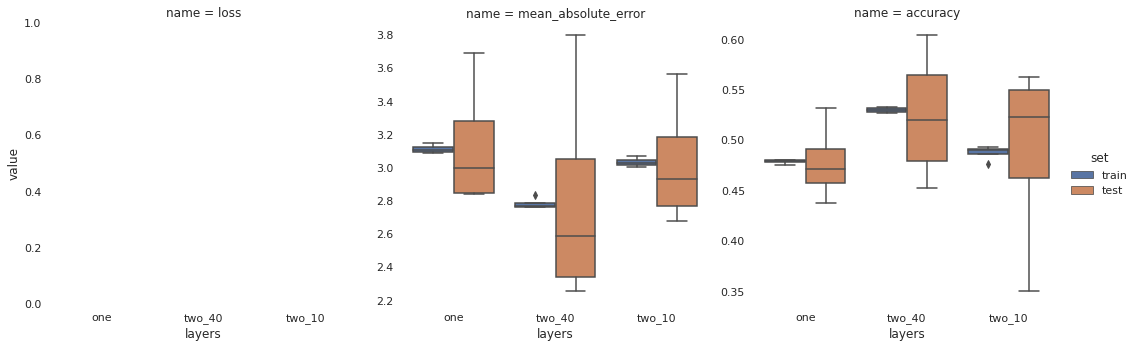

In [ ]:
selection = best_labels['accuracy'].copy()

focus = 'layers'

selection.pop(focus)
# selection['set'] = 'test'
selection['epoch'] = 990

w = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)


sns.catplot(data=metrics_df[w], x='layers', y='value', col='name', kind='box', hue='set', sharey=False)

### Results


## Confusion Matrix

<AxesSubplot:title={'center':'Ordinal target encoding'}, xlabel='y_pred', ylabel='y_true'>

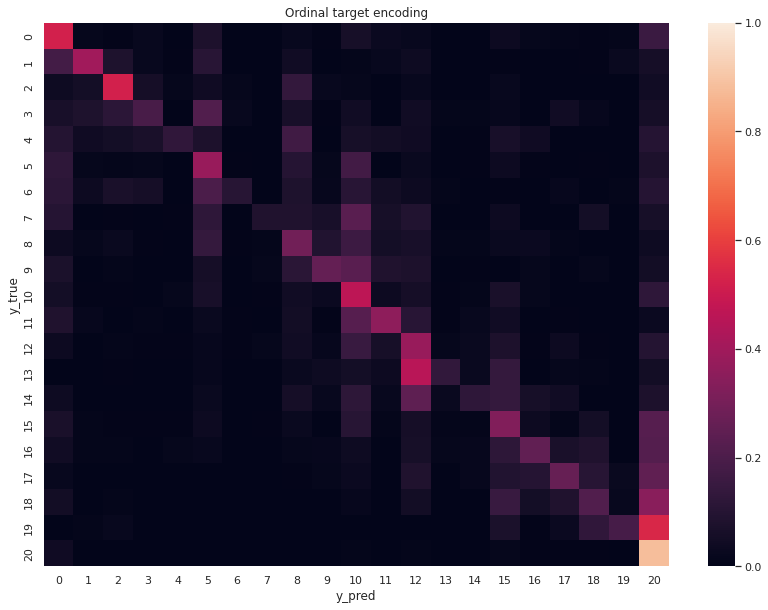

In [ ]:
# Todo: double check the normalisation
w = pd.concat(
    (confusion_matrix_df[k] == v
    for k,v in best_labels['accuracy'].items()), axis=1
).all(1)

cm_g_df = confusion_matrix_df[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
plt.title('Ordinal target encoding')
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)
# # plt.savefig(os.path.join(plot_folder, 'confusion_matrix.jpg'), dpi=300, transparent=False)

<AxesSubplot:title={'center':'Ordinal target encoding'}, xlabel='y_pred', ylabel='y_true'>

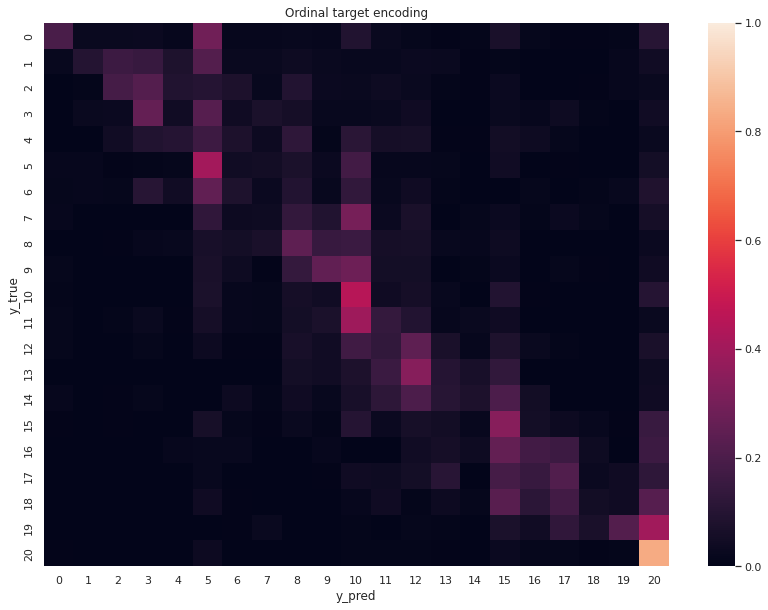

In [ ]:
w = pd.concat(
    (confusion_matrix_df[k] == v
    for k,v in best_labels['mean_absolute_error'].items()), axis=1
).all(1)

cm_g_df = confusion_matrix_df[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
plt.title('Ordinal target encoding')
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)

### Interpretation

The confusion matrix looks nicely diagonal. Maybe the previous results can be confirmed here. 
* Ordinal traget: diagonal less prominent, but errors close to diagonal
* Non ordinal target: diagonal more prominent, more errors with 0 and 20 (y_pred)

## Response analysis

(For the lack of a better term)

### Question

How are the predicted contributions respond to changes in contributions?

/tmp/ipykernel_22519/2191569887.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['exp_contribution'] = df['proba']


<AxesSubplot:xlabel='prev_punishment', ylabel='prev_contribution'>

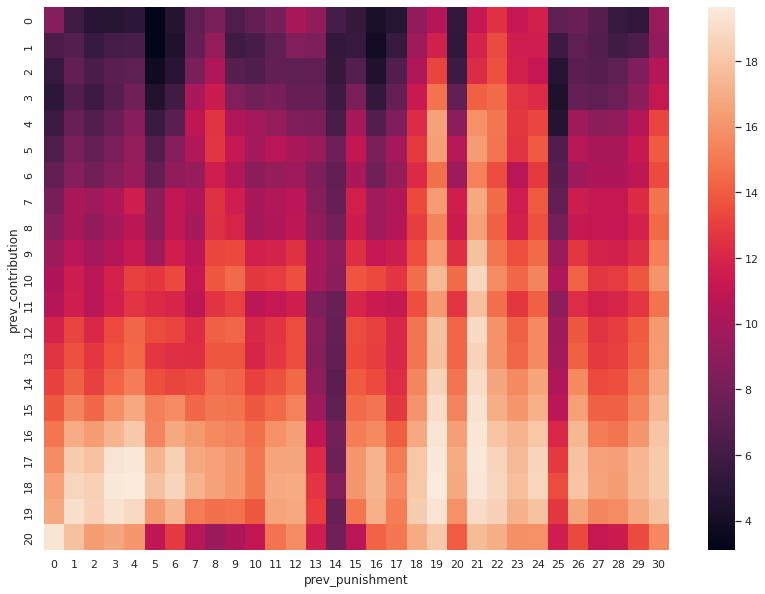

In [ ]:
selection = best_labels['mean_absolute_error'].copy()

selection['layers'] = 'two_10'

w = pd.concat(
    (synthethetic_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

df = synthethetic_df[w]

if df['y_encoding'].unique()[0] == 'ordinal':
    df['exp_contribution'] = df['proba']
else:
    df['exp_contribution'] = df['contribution'] * df['proba']

dfg = df.groupby([*labels, 'set', 'cv_split', 'prev_contribution', 'round', 'prev_punishment',
       'sample_idx'])['exp_contribution'].sum()
dfg = dfg.reset_index()

cm = dfg.pivot_table(index=['prev_contribution'], columns='prev_punishment', values='exp_contribution')

plt.figure(figsize=(14,10))
sns.heatmap(cm)

In [ ]:
df['y_encoding'].unique()[0]

'ordinal'

## Interpretation

* in particular when using ordinal encoding for the interaction term, an pattern emerges, in which the prev_punishment should be at least as large as (prev_contribution - 20)

A algorithm playing against this model, would select for each prev_contribution the smallest punishment, that still leads to a large expected contribution. I.e. punishment ~  (prev_contribution - 20).

## Conclusions

* Ordinal encoding works well for inputs, for the output it is not yet clear if an ordinal approach is beneficial
* Overall performance is good. That might however also just be a effect of participants being very repetitive in their contributions {in an further analysis we should look at the importance of the different components}
* The response surface is promising, however in the current setup relative noisy.

## Limitations
* the model is overspecified as the interaction includes the direct effects

## Potential Next Steps
* Learning curves
* Contributions of each factor (prev_p, prev_c, interactions)
* MLP model (smoother?!)